# Logistic Regression

**Note: As I have taken only 100k points(due to less RAM) the f1-score will not be the representive of the real score**

# Loading data

In [15]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'aren', 'shouldn', 'after', "isn't", "aren't", 'such', 'a', 'your', 'do', 'at', "you'll", "hadn't", 'weren', "wasn't", 'herself', 'ma', 'while', 'can', 'but', 'by', "won't", 'was', 'where', "you're", 'what', 'each', 'she', "couldn't", 'been', 'himself', 'we', 'if', 'here', 'their', 'hadn', 'does', 'won', 't', 'not', 'up', 'themselves', 'them', 'only', 'this', 'now', 'needn', 'has', 'the', 'll', 'wasn', 'as', 're', 'further', 'few', 'too', 'having', 'me', 'didn', 'her', 'down', 'so', 'which', 'nor', "wouldn't", 'my', "weren't", 'more', 'again', 'from', 'm', 'over', 'y', "that'll", 'they', 'with', 'yourselves', 'just', 'hasn', 'once', 'against', 'until', 'because', 'in', 'couldn', 'ourselves', 'theirs', 'there', 'mustn', 'haven', "shan't", "haven't", 'both', 've', 'on', 'some', 'doing', "she's", 'about', 'during', 'be', 'own', "it's", 'ours', 'out', 'don', 'yourself', 's', "should've", "doesn't", "hasn't", 'hers', 'same', 'will', 'ain', 'or', 'for', 'those', 'you', 'of', 'o', 'these', '

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [09:02<00:00, 671.36it/s]


In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
final.to_pickle("./preprocessed.pkl")

In [20]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle("./preprocessed.pkl")

In [0]:
# Random sampling 
data = data.take(np.random.permutation(len(data))[:100000])

# [2] Sorting data based on time

In [23]:
data['Time'] = pd.to_datetime(data['Time'])
# Sort by time
data = data.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(100000, 12)
1    84369
0    15631
Name: Score, dtype: int64


# [3] Spliting into train and test based on time (70:30)

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

# [4] Bag of Words (BoW)

In [25]:
#Bag of words
count_vect = CountVectorizer(max_features=2000, min_df=10) 

X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


## [4.1] Logistic Regression with GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression()
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(clf,param_grid,cv=tscv, scoring = 'f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy: 91.00%


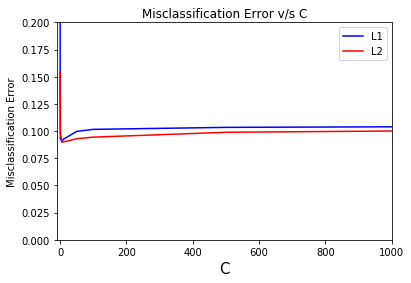

In [0]:
def plot_grid(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
            
    plt.xlim(-10,1000)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()
plot_grid(gsv)

In [0]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Accuracy on test set: 90.827%
Precision on test set: 0.924
Recall on test set: 0.968
F1-Score on test set: 0.946


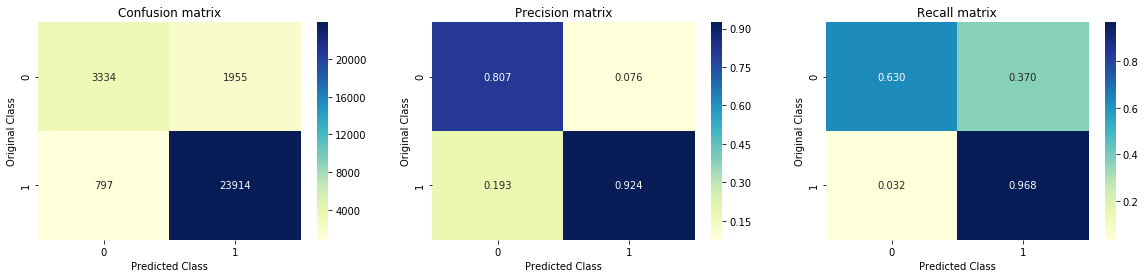

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

### Sparsity decreases as we increase C (decrease lambda) when we use L1 regularization.

In [0]:
clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
w = clf.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 211


In [0]:
clf = LogisticRegression(C=1, penalty= 'l1')
clf.fit(X_train,y_train)
w = clf.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 1035


In [0]:
clf = LogisticRegression(C=10, penalty= 'l1')
clf.fit(X_train,y_train)
w = clf.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 1864


In [0]:
clf = LogisticRegression(C=100, penalty= 'l1')
clf.fit(X_train,y_train)
w = clf.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 1980


In [0]:
clf = LogisticRegression(C=1000, penalty= 'l1')
clf.fit(X_train,y_train)
w = clf.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 1997


## [4.2] Logistic Regression with RandomSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression()
param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 10}
Best Accuracy: 91.00%


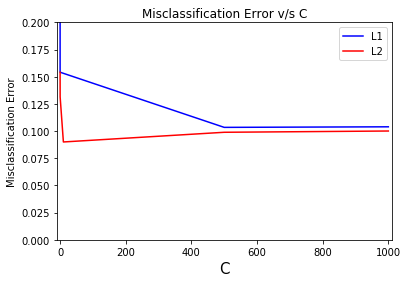

In [0]:
def plot_random(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()

plot_random(gsv)

Accuracy on test set: 90.827%
Precision on test set: 0.924
Recall on test set: 0.968
F1-Score on test set: 0.946


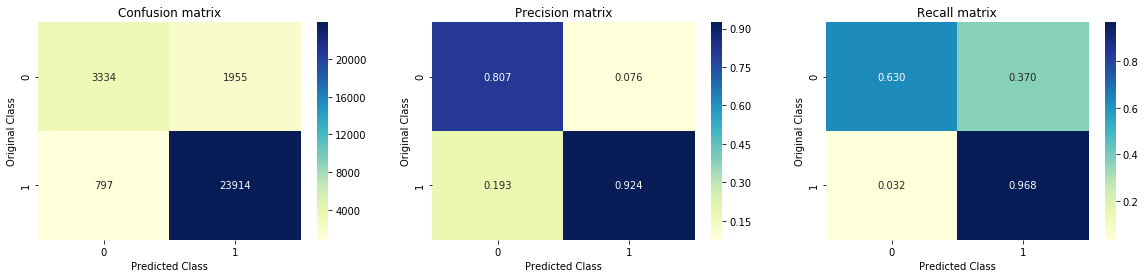

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.3] Pertubation Test

In [28]:
# Training without adding random noise
from sklearn.linear_model import LogisticRegression

clf_1 = LogisticRegression(C= 10, penalty= 'l2')
clf_1.fit(X_train,y_train)
y_pred = clf_1.predict(X_test)
w = clf_1.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 2000


In [29]:
from scipy.sparse import find
weights1 = find(clf_1.coef_[0])[2]   #Before adding random noise
print(weights1[:25])

[ 2.53884178  0.56166547 -1.16550798 -1.17768014  0.2537655   1.68209946
 -1.40979413 -0.45032737  2.82565471  3.02411362 -3.55134649  3.77852495
 -0.04168942  0.14634732  2.33800161  8.30910101  1.37888853  0.8308018
  1.55527807  0.6632748   0.0397493  -0.74746896 -3.54932033 -1.79461531
  0.79938394]


In [0]:
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))     #Random noise
a,b,c = find(X_train_t)                     #value of non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]   #Adding random noise to non-zero datapoints

In [31]:
#Train After adding random noise
clf_2 = LogisticRegression(C= 10, penalty= 'l2')
clf_2.fit(X_train_t,y_train)
y_pred = clf_2.predict(X_test)
w = clf_2.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 2000


In [33]:
weights2 = find(clf_2.coef_[0])[2]    #After adding random noise
print(weights2[:25])

[ 2.5392987   0.56244696 -1.16491169 -1.17868225  0.25430308  1.68065299
 -1.40644667 -0.45095084  2.82369965  3.02385544 -3.54933025  3.77663666
 -0.04163202  0.14736094  2.33766087  8.31485394  1.37914659  0.82938795
  1.55413765  0.66510584  0.037964   -0.74694182 -3.54903574 -1.79450578
  0.80109755]


In [34]:
# Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
epsilon = 0.000001
weights1 = weights1 + epsilon
print(weights1[:25])

weights2 = weights2 + epsilon
print(weights2[:25])

[ 2.53884278  0.56166647 -1.16550698 -1.17767914  0.2537665   1.68210046
 -1.40979313 -0.45032637  2.82565571  3.02411462 -3.55134549  3.77852595
 -0.04168842  0.14634832  2.33800261  8.30910201  1.37888953  0.8308028
  1.55527907  0.6632758   0.0397503  -0.74746796 -3.54931933 -1.79461431
  0.79938494]
[ 2.5392997   0.56244796 -1.16491069 -1.17868125  0.25430408  1.68065399
 -1.40644567 -0.45094984  2.82370065  3.02385644 -3.54932925  3.77663766
 -0.04163102  0.14736194  2.33766187  8.31485494  1.37914759  0.82938895
  1.55413865  0.66510684  0.037965   -0.74694082 -3.54903474 -1.79450478
  0.80109855]


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [52]:
print(weights_diff[np.where(weights_diff > 0)].size)
print(weights_diff[np.where(weights_diff > 0.1)].size)
print(weights_diff[np.where(weights_diff > 0.2)].size)
print(weights_diff[np.where(weights_diff > 0.3)].size)
print(weights_diff[np.where(weights_diff > 0.4)].size)
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 50)].size)

1035
464
244
156
116
2
0


In [0]:
# feature names whose % change is more than a threshold x
df = pd.DataFrame(data=(abs(weights1 - weights2)/weights1) * 100 > 0.1, index=count_vect.get_feature_names())

In [49]:
df[df[0]] == True

,0
absolut,True
accept,True
ad,True
adjust,True
ador,True
adult,True
affect,True
afraid,True
agav,True
age,True


**464 features weight changes more than 0.1%. Hence, the features are very least multicollinear **

## [4.4] Feature Importance

In [0]:
def feature_Importance(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\tNegative\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
feature_Importance(count_vect,clf)

	Negative					Positive
________________________________________________________________________________________________
	-6.1949	return         				6.1828	best           
	-6.1287	terribl        				6.1274	great          
	-5.7197	aw             				5.2357	nice           
	-5.3374	worst          				5.0679	delici         
	-4.9676	item           				5.0426	excel          
	-4.9392	disappoint     				4.7025	love           
	-4.7756	unfortun       				4.6856	friend         
	-4.7389	money          				4.2607	tasti          
	-4.5875	poor           				4.1283	oliv           
	-4.3179	lack           				3.9651	calori         
	-4.2911	stale          				3.6016	right          
	-4.2213	disgust        				3.5969	ask            
	-4.1937	corn           				3.5579	quit           
	-4.0537	sorri          				3.5170	smooth         
	-4.0521	noth           				3.4415	wonder         
	-4.0088	know           				3.3048	snack          
	-3.7825	guess          				3.2875	favorit        
	-3.7291	odd 

# [5] TF-IDF

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [126]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=2000, min_df=10) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

#Normalize Data
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 2000)
Test Data Size:  (30000, 2000)


## [5.1] Logistic Regression with GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression()

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  9.5min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 91.09%


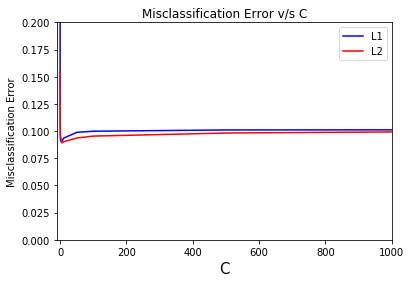

In [0]:
plot_grid(gsv)

Accuracy on test set: 90.957%
Precision on test set: 0.925
Recall on test set: 0.969
F1-Score on test set: 0.946


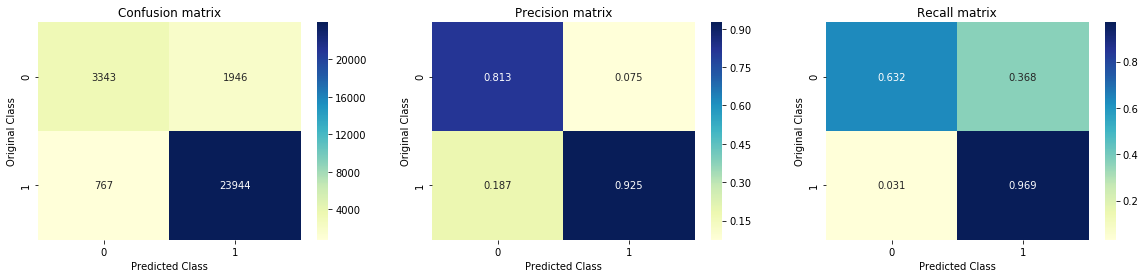

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.2] Logistic Regression with RandomSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression()
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 91.00%


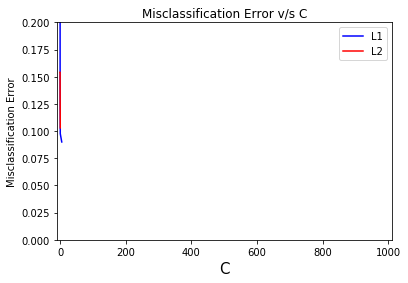

In [0]:
plot_random(gsv)

Accuracy on test set: 90.943%
Precision on test set: 0.927
Recall on test set: 0.966
F1-Score on test set: 0.946


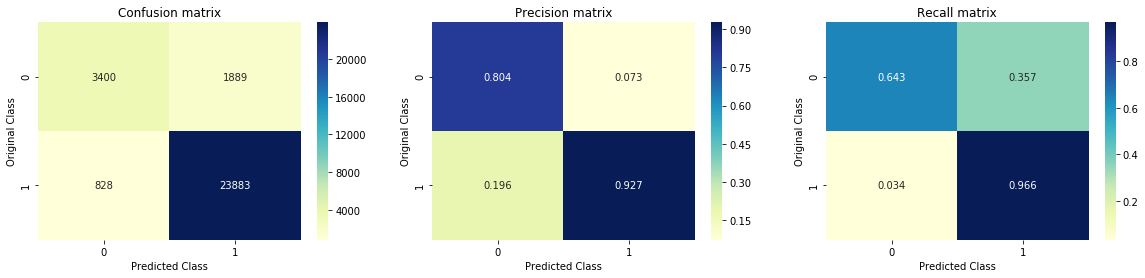

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.3] Pertubation Test

In [127]:
# Training without random noise
clf_1 = LogisticRegression(C= 10, penalty= 'l2')
clf_1.fit(X_train,y_train)
y_pred = clf_1.predict(X_test)
w = clf_1.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 2000


In [128]:
weights1 = find(clf_1.coef_[0])[2]     #Before adding random noise
print(weights1[:25])

[ 2.4297598   0.36799227  0.28453863 -0.11589619  0.60027366  2.26677927
 -1.08631603  0.43512875 -0.96435615 -0.37383112  2.54860667  3.09273893
 -0.08402779  1.84796849  0.37017745 -2.36302397  2.65437909  3.19093861
  1.86476903  7.67010342  1.18625835  1.32827046  0.98450191  0.03986242
 -2.5470499 ]


In [0]:
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))     #Random noise
a,b,c = find(X_train_t)                     #value of non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]   #Adding random noise to non-zero datapoints

In [130]:
clf_2 = LogisticRegression(C= 10, penalty= 'l2')    #train data with random noise
clf_2.fit(X_train_t,y_train)
y_pred = clf_2.predict(X_test)
w = clf_2.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 2000


In [131]:
weights2 = find(clf_2.coef_[0])[2]   #After adding random noise
print(weights2[:25])

[ 2.42942549  0.36765559  0.28445656 -0.11644125  0.60083253  2.26783345
 -1.08759     0.43513483 -0.96490564 -0.37396918  2.54858871  3.09300851
 -0.08452832  1.84801811  0.3699241  -2.36263227  2.65384581  3.19214906
  1.86440244  7.6698813   1.1859893   1.32796609  0.98413486  0.03937274
 -2.54707366]


In [132]:
# Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
epsilon = 0.000001
weights1 = weights1 + epsilon
print(weights1[:25])

weights2 = weights2 + epsilon
print(weights2[:25])

[ 2.4297608   0.36799327  0.28453963 -0.11589519  0.60027466  2.26678027
 -1.08631503  0.43512975 -0.96435515 -0.37383012  2.54860767  3.09273993
 -0.08402679  1.84796949  0.37017845 -2.36302297  2.65438009  3.19093961
  1.86477003  7.67010442  1.18625935  1.32827146  0.98450291  0.03986342
 -2.5470489 ]
[ 2.42942649  0.36765659  0.28445756 -0.11644025  0.60083353  2.26783445
 -1.087589    0.43513583 -0.96490464 -0.37396818  2.54858971  3.09300951
 -0.08452732  1.84801911  0.3699251  -2.36263127  2.65384681  3.19215006
  1.86440344  7.6698823   1.1859903   1.32796709  0.98413586  0.03937374
 -2.54707266]


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [134]:
print(weights_diff[np.where(weights_diff > 0)].size)
print(weights_diff[np.where(weights_diff > 0.1)].size)
print(weights_diff[np.where(weights_diff > 0.2)].size)
print(weights_diff[np.where(weights_diff > 0.3)].size)
print(weights_diff[np.where(weights_diff > 0.4)].size)
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 50)].size)

1093
158
82
61
45
4
1


In [135]:
# feature names whose % change is more than a threshold x
df = pd.DataFrame(data=(abs(weights1 - weights2)/weights1) * 100 > 0.1, index=tfidf.get_feature_names())
df[df[0]] == True

,0
adult,True
alon,True
alreadi,True
also make,True
also tri,True
anim,True
antioxid,True
arriv,True
bag,True
best coffe,True


**300 features weight changes more than 0.1%. Hence, the features are very least multicollinear **

## [5.4] Feature Importance

In [0]:
def feature_Importance(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\tNegative\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,clf)

	Negative				Positive
________________________________________________________________________________________________
	-11.7203	worst          				15.3601	high recommend 
	-9.9496	disgust        				11.5454	great          
	-8.8536	disappoint     				11.4623	delici         
	-8.4587	terribl        				9.6159	perfect        
	-8.3977	aw             				9.2750	excel          
	-8.2774	wont buy       				9.0449	best           
	-7.4986	threw          				8.9778	pleasant surpris
	-7.4692	tasteless      				8.0526	addict         
	-7.4270	horribl        				7.7822	love           
	-7.3466	return         				7.7763	amaz           
	-7.0298	bland          				7.7436	awesom         
	-6.7355	unpleas        				7.5707	even better    
	-6.6366	refund         				7.4189	hook           
	-6.4484	never buy      				6.9770	worri          
	-6.3274	stale          				6.8957	yum            
	-6.3099	wors           				6.8007	right amount   
	-6.2065	poor           				6.4689	satisfi        
	-6.1290	

# [6] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [65]:
print(data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

twist rumplestiskin captur film star michael keaton geena davi prime tim burton masterpiec rumbl absurd wonder pace point dull moment
*****************************************************************
['twist', 'rumplestiskin', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment']


In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [67]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12537
sample words  ['twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment', 'beetlejuic', 'excel', 'funni', 'movi', 'hilari', 'great', 'special', 'effect', 'help', 'think', 'one', 'best', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch', 'bought', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'mani', 'within', 'day', 'practic']


# [7] Avg Word2Vec

In [68]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 100000/100000 [02:25<00:00, 686.81it/s]

100000
50


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [7.1] Logistic Regression with GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(max_iter=100)

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.5min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 89.40%


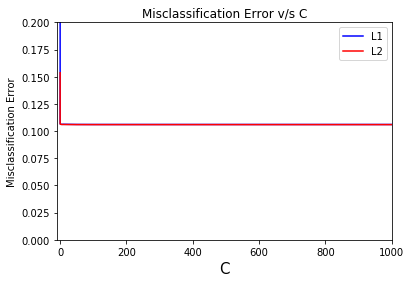

In [0]:
plot_grid(gsv)

Accuracy on test set: 88.490%
Precision on test set: 0.902
Recall on test set: 0.966
F1-Score on test set: 0.933


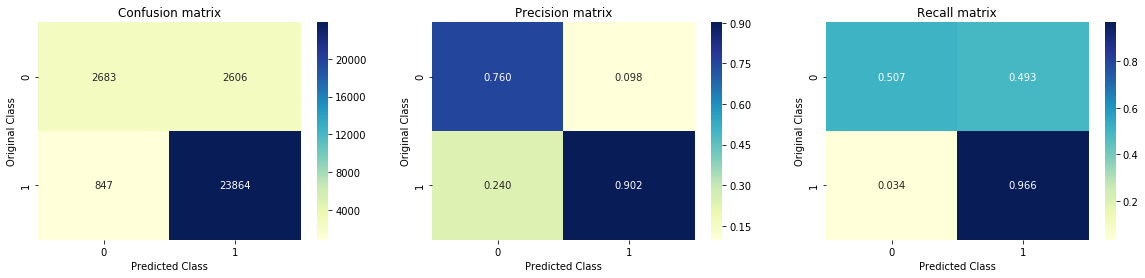

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [7.2] Logistic Regression with RandomSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression(max_iter=100)
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.4min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 1000}
Best Accuracy: 89.40%


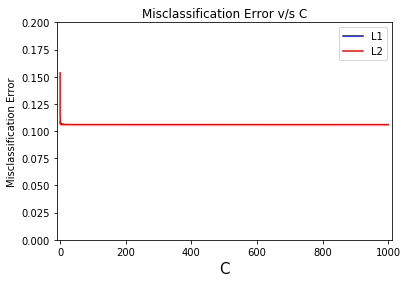

In [0]:
plot_random(gsv)

Accuracy on test set: 88.490%
Precision on test set: 0.902
Recall on test set: 0.966
F1-Score on test set: 0.933


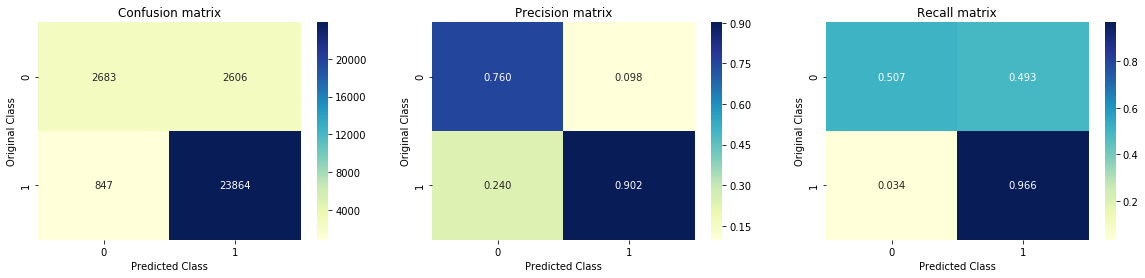

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [7.3] Pertubation Test

In [93]:
clf_1 = LogisticRegression(C= 1000, penalty= 'l2')
clf_1.fit(X_train,y_train)
y_pred = clf_1.predict(X_test)
w=clf_1.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 50


In [94]:
weights1 = find(clf_1.coef_[0])[2]    #Before adding random noise
print(weights1[:20])

[ 0.20817148 -0.51055397 -0.00435209  0.49896239  0.79431864  1.4453521
  0.23580731 -0.83598098 -0.43695513 -0.58346914  0.91388318  0.35752245
  0.71330324 -0.62613027  0.04348307 -0.41645162  0.28431257  0.51027533
  0.01017499 -0.61802459]


In [0]:
X_train = preprocessing.normalize(X_train)
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)      #Value of non-zero datapoints

X_train_t[a,b] = epsilon + X_train_t[a,b]     #Adding noise to non-zero datapoints

In [96]:
clf_2 = LogisticRegression(C= 10, penalty= 'l2')    #Train data having random noise
clf_2.fit(X_train_t,y_train)
y_pred = clf_2.predict(X_test)
w=clf_2.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 50


In [97]:
weights2 = find(clf_2.coef_[0])[2]      #After adding random noise
print(weights2[:20])

[ 1.4395561  -0.41068083 -0.29749648  2.11749526  1.77088839  4.11083438
 -0.52583832 -2.05943108 -1.48055019 -2.1584912   3.46913814  1.12015471
  1.01028074 -0.7419525  -0.23478578 -0.71668284  2.00144003  2.06629972
  1.46198892 -0.54708415]


In [98]:
# Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
epsilon = 0.000001
weights1 = weights1 + epsilon
print(weights1[:25])

weights2 = weights2 + epsilon
print(weights2[:25])

[ 0.20817248 -0.51055297 -0.00435109  0.49896339  0.79431964  1.4453531
  0.23580831 -0.83597998 -0.43695413 -0.58346814  0.91388418  0.35752345
  0.71330424 -0.62612927  0.04348407 -0.41645062  0.28431357  0.51027633
  0.01017599 -0.61802359 -1.83892342 -0.24880665 -0.86188123  0.60477123
 -1.14310856]
[ 1.4395571  -0.41067983 -0.29749548  2.11749626  1.77088939  4.11083538
 -0.52583732 -2.05943008 -1.48054919 -2.1584902   3.46913914  1.12015571
  1.01028174 -0.7419515  -0.23478478 -0.71668184  2.00144103  2.06630072
  1.46198992 -0.54708315 -6.88247796 -0.99264812 -1.10687578  2.24645189
 -3.74691053]


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [105]:
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 20)].size)
print(weights_diff[np.where(weights_diff > 30)].size)
print(weights_diff[np.where(weights_diff > 40)].size)
print(weights_diff[np.where(weights_diff > 50)].size)
print(weights_diff[np.where(weights_diff > 60)].size)
print(weights_diff[np.where(weights_diff > 70)].size)
print(weights_diff[np.where(weights_diff > 80)].size)
print(weights_diff[np.where(weights_diff > 90)].size)
print(weights_diff[np.where(weights_diff > 100)].size)

25
25
25
24
23
22
22
22
21
21


**24 features weight changes more than 40%. Hence, the features are multicollinear **

# [8] TF-IDF Word2Vec

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [112]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 100000/100000 [03:17<00:00, 506.01it/s]


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [8.1] Logistic Regression with GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(max_iter=100)

param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.5min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 87.97%


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


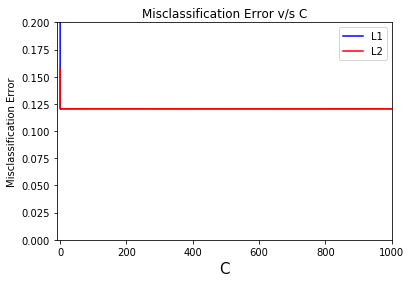

In [0]:
plot_grid(gsv)

Accuracy on test set: 88.430%
Precision on test set: 0.902
Recall on test set: 0.967
F1-Score on test set: 0.934


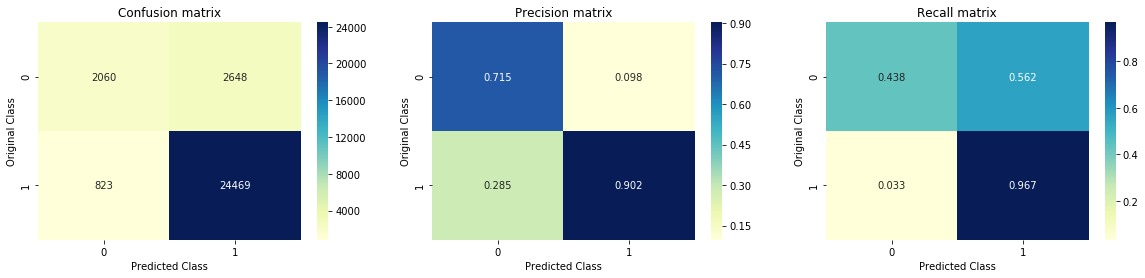

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [8.2] Logistic Regression with RandomSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression(max_iter=100)
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) 
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv, scoring='f1_micro', verbose=1, n_jobs = -1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.1min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 87.97%


C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


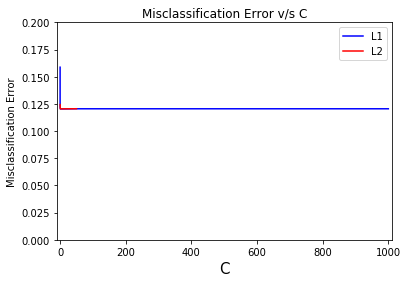

In [0]:
plot_random(gsv)

Accuracy on test set: 88.430%
Precision on test set: 0.902
Recall on test set: 0.967
F1-Score on test set: 0.934


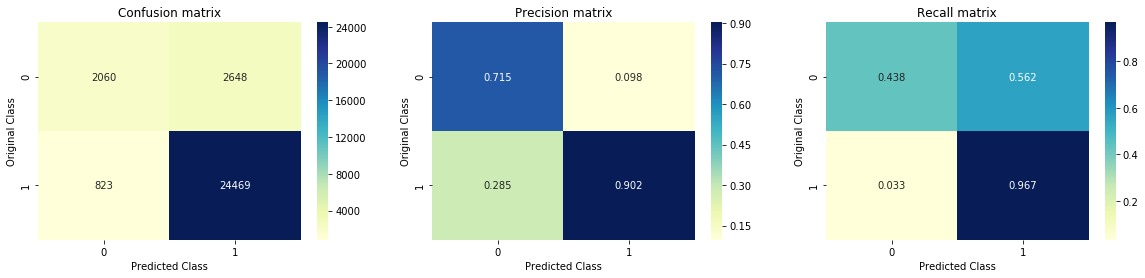

In [0]:
#Testing Accuracy on Test data
clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [8.3] Pertubation Test

In [115]:
clf_1 = LogisticRegression(C= 500, penalty= 'l2')
clf_1.fit(X_train,y_train)
y_pred = clf_1.predict(X_test)
w=clf_1.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 50


In [116]:
weights1 = find(clf_1.coef_[0])[2]       #Before adding random noise
print(weights1[:25])

[ 0.22990601 -0.54614728 -0.16952061  0.11868524  0.56601246  1.20741507
  0.31193965 -0.82413947 -0.45181008 -0.34751996  0.8471061   0.3265579
  0.66942314 -0.52487757  0.12732448 -0.32554214  0.2208702   0.41044978
 -0.12283878 -0.71105966 -1.30715928 -0.06837285 -1.01145984  0.328391
 -1.2548142 ]


In [0]:
X_train = preprocessing.normalize(X_train)
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)   #Value of non-zero datapoints

X_train_t[a,b] = epsilon + X_train_t[a,b]    #Adding noise to non-zero datapoints

In [118]:
clf_2 = LogisticRegression(C= 10, penalty= 'l2')    #Train data having random noise
clf_2.fit(X_train_t,y_train)
y_pred = clf_2.predict(X_test)
w=clf_2.coef_
print("Non Zero weights:",np.count_nonzero(w))

Non Zero weights: 50


In [119]:
weights2 = find(clf_2.coef_[0])[2]      #After adding random noise
print(weights2[:25])

[ 1.69778278e+00 -5.11877483e-01 -7.54792394e-01  1.12956661e+00
  9.76475455e-01  3.14819971e+00 -5.61805010e-01 -2.05394810e+00
 -1.57890188e+00 -1.42157237e+00  3.38053770e+00  1.26364785e+00
  7.14959663e-01 -7.69098444e-02 -2.02130075e-03 -2.15659825e-01
  2.13097630e+00  1.66549710e+00  1.24507670e+00 -4.22571398e-01
 -5.57509927e+00 -3.05883961e-01 -1.23431512e+00  1.36883392e+00
 -4.11993983e+00]


In [120]:
# Add the small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
epsilon = 0.000001
weights1 = weights1 + epsilon
print(weights1[:25])

weights2 = weights2 + epsilon
print(weights2[:25])

[ 0.22990701 -0.54614628 -0.16951961  0.11868624  0.56601346  1.20741607
  0.31194065 -0.82413847 -0.45180908 -0.34751896  0.8471071   0.3265589
  0.66942414 -0.52487657  0.12732548 -0.32554114  0.2208712   0.41045078
 -0.12283778 -0.71105866 -1.30715828 -0.06837185 -1.01145884  0.328392
 -1.2548132 ]
[ 1.69778378e+00 -5.11876483e-01 -7.54791394e-01  1.12956761e+00
  9.76476455e-01  3.14820071e+00 -5.61804010e-01 -2.05394710e+00
 -1.57890088e+00 -1.42157137e+00  3.38053870e+00  1.26364885e+00
  7.14960663e-01 -7.69088444e-02 -2.02030075e-03 -2.15658825e-01
  2.13097730e+00  1.66549810e+00  1.24507770e+00 -4.22570398e-01
 -5.57509827e+00 -3.05882961e-01 -1.23431412e+00  1.36883492e+00
 -4.11993883e+00]


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [123]:
print(weights_diff[np.where(weights_diff > 0.1)].size)
print(weights_diff[np.where(weights_diff > 10)].size)
print(weights_diff[np.where(weights_diff > 20)].size)
print(weights_diff[np.where(weights_diff > 30)].size)
print(weights_diff[np.where(weights_diff > 40)].size)
print(weights_diff[np.where(weights_diff > 50)].size)
print(weights_diff[np.where(weights_diff > 60)].size)
print(weights_diff[np.where(weights_diff > 70)].size)
print(weights_diff[np.where(weights_diff > 80)].size)
print(weights_diff[np.where(weights_diff > 90)].size)
print(weights_diff[np.where(weights_diff > 100)].size)

25
23
23
22
22
22
21
21
20
20
20


**23 features weight changes more than 10%. Hence, the features are multicollinear **

# Performance Table

In [0]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "MODEL", "C","PENALTY", "F1-SCORE", "ACCURACY"]
 
x.add_row(["BOW", "Grid Search", 10, "L2",0.946, 90.827]) 
x.add_row(["", "Random Search", 10, "L2", 0.946, 90.827]) 
x.add_row(["TF_IDF", "Grid Search", 5, "L2", 0.946, 90.957]) 
x.add_row(["", "Random Search", 5, "L1", 0.946, 90.943])
x.add_row(["AVG_W2VEC", "Grid Search", 1000, "L2", 0.933, 88.490]) 
x.add_row(["", "Random Search", 1000, "L2",  0.933, 88.490])
x.add_row(["TFIDF_W2VEC", "Grid Search", 1, "L1", 0.934, 88.430]) 
x.add_row(["", "Random Search", 1, "L1", 0.934, 88430])
 
print(x)

+---------------+---------------+------+---------+----------+----------+
| FEATURIZATION |     MODEL     |  C   | PENALTY | F1-SCORE | ACCURACY |
+---------------+---------------+------+---------+----------+----------+
|      BOW      |  Grid Search  |  10  |    L2   |  0.946   |  90.827  |
|               | Random Search |  10  |    L2   |  0.946   |  90.827  |
|     TF_IDF    |  Grid Search  |  5   |    L2   |  0.946   |  90.957  |
|               | Random Search |  5   |    L1   |  0.946   |  90.943  |
|   AVG_W2VEC   |  Grid Search  | 1000 |    L2   |  0.933   |  88.49   |
|               | Random Search | 1000 |    L2   |  0.933   |  88.49   |
|  TFIDF_W2VEC  |  Grid Search  |  1   |    L1   |  0.934   |  88.43   |
|               | Random Search |  1   |    L1   |  0.934   |  88430   |
+---------------+---------------+------+---------+----------+----------+


# Observations

1. Sparsity increases as we decrease C (increase lambda) when we use L1 Regularizer for regularization.
2. TF_IDF Featurization performs best with F1_score of 0.946 and Accuracy of 90.957.
3. Features are multi-collinear with different featurization.
4. Logistic Regression is faster algorithm.